In [26]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.animation import FuncAnimation
from scipy.stats import uniform
from observision_models import NormalObservation
from IPython.display import HTML

from ball_throwing_simulator import BallThrowingSimulator

# Simulate ball throwing and generate Observations

(4, 1)
(61, 4, 1) (60, 2, 1)


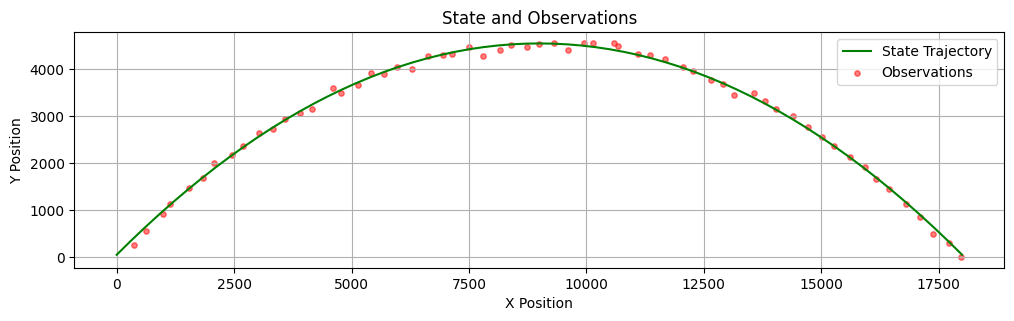

In [27]:
ball_num = 1
init_state = np.array([[0], [50], [300], [300]])  # Initial state: [x, y, vx, vy]
simulator = BallThrowingSimulator(delta_t=0.5, init_state=init_state, ball_num=ball_num, observation_variance=[10, 10])
# Simulate the motion and observations
states, observations = simulator.simulate(time=30)
print(states.shape, observations.shape)
# Show the simulated states and observations
fig, ax = plt.subplots(figsize=(12, 12))
plot_observations(ax, states, observations)

# Initilaize
## State
$$[X, Y, V_x, V_y]^T$$

## Uniform Random Particle Sets
$$X, Y \in [0, 3000]$$
$$V_x, V_y \in [0, 200]$$

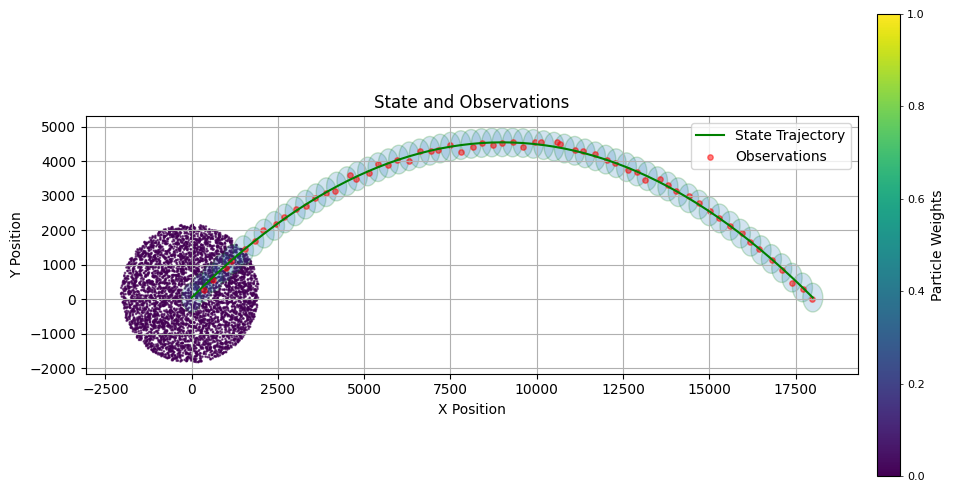

In [28]:
from partickle_filter import ParticleFilter
pf = ParticleFilter(5000)

init_particles, init_weights = pf.snaps[0]

# show initial particles
fig, ax = plt.subplots(figsize=(12, 12))
# ax.set_xlim(0, 3000)
# ax.set_ylim(0, 3000)
ax.set_title('Initial Particles')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
plot_particles(ax, init_particles, init_weights)
plot_observations(ax, states, observations, NormalObservation.R)
plt.show()

IndexError: index 60 is out of bounds for axis 0 with size 60

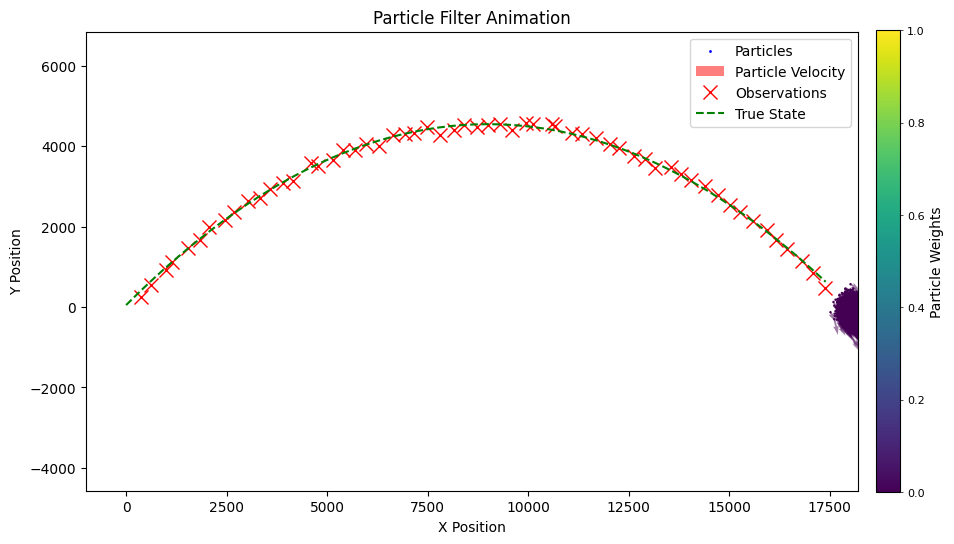

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_title('Particle Filter Animation')

# 确保轴的范围是基于所有状态和观测的，而不是只取第一帧
all_x = np.concatenate((states[:, 0], observations[:, 0]))
all_y = np.concatenate((states[:, 1], observations[:, 1]))

# 增加一些边界以防粒子跑出视图
x_min, x_max = np.min(all_x) - 1000, np.max(all_x) + 200
y_min, y_max = -np.max(all_y), 1.5*np.max(all_y)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_aspect('equal', adjustable='box') # 保持坐标轴比例一致，避免椭圆变形

# 初始化用于动画的图元
# 散点图的集合 (Collection) 用于粒子，线条用于观测和真实状态
# 注意：plt.plot 返回的是一个列表，需要解包
probs_colormap = 'viridis'

particles_scatter = ax.scatter([], [], s=[], alpha=1, c='blue', label='Particles')
# scale=None 允许 Matplotlib 自动缩放箭头长度， scale_units='xy' 让箭头的长度单位与坐标轴单位一致
particles_quiver = ax.quiver([0]*pf.N,[0]*pf.N,[0]*pf.N,[0]*pf.N, angles='xy', scale_units='xy',
              scale=1, color='red', alpha=0.5, label='Particle Velocity') # label for legend

observations_plot, = ax.plot([], [], 'rx', markersize=10, label='Observations')
true_state_plot, = ax.plot([], [], 'g--', label='True State') # 如果有真实状态

# add color bar
sm = plt.cm.ScalarMappable(
        cmap=probs_colormap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.5, pad=0.02)
cbar.set_label('Particle Weights')
# make colorbar smaller
cbar.ax.tick_params(labelsize=8, length=2, width=0.5)

# 添加图例
ax.legend()

# 2. 定义更新函数
def update(frame):
    global particles, weights # 声明使用全局变量    
        
    particles_scatter.set_offsets(particles[:,:2].reshape(-1, 2)) # Ensure shape is (N, 2)
    particles_scatter.set_color(colormaps.get_cmap(probs_colormap)(weights))
    # 补全 quiver 部分
    # 获取粒子的速度 (vx, vy) 作为箭头的方向分量
    quiver_U = particles[:, 2].flatten() # vx
    quiver_V = particles[:, 3].flatten() # vy

    particles_quiver.set_offsets(particles[:,:2].reshape(-1, 2)) # Update origin
    particles_quiver.set_UVC(quiver_U, quiver_V) # Update direction and color (if C is provided)
    particles_quiver.set_color(colormaps.get_cmap(probs_colormap)(weights))

    # 更新观测数据，只显示到当前帧为止的观测
    if frame>0:
        current_observations = observations[:min(frame-1, observations.shape[0])]
        observations_plot.set_data(current_observations[:, 0], current_observations[:, 1])
        particles, weights = pf.update(particles, weights, observations[frame-1])

    # 更新真实状态数据（如果存在）
    current_states = states[:min(frame, states.shape[0])]
    true_state_plot.set_data(current_states[:, 0], current_states[:, 1])
  
    plt.savefig(f"outputs/frame_{frame:03.0f}.png") # Uncomment to save individual frames

    # 返回所有需要更新的图元
    return particles_scatter, particles_quiver, observations_plot, true_state_plot # Add particles_quiver here

# 3. 创建 FuncAnimation 对象
# frames: 动画的总帧数，这里是观测的数量 + 1 (为了包含初始帧)
# interval: 每帧之间的毫秒数
# blit: True 可以优化性能，只重绘变化的图元
particles, weights = pf.snaps[0]
ani = FuncAnimation(fig, func=update, frames=states.shape[0], interval=100, blit=True)

# 4. 显示动画
# plt.show()
HTML(ani.to_jshtml())

ani.save('particle_filter_animation.gif', writer='imagemagick', fps=1) # Uncomment to save as GIF